#Mount Drive + Load Libraries#

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/Shareddrives/CSCI 461'

Mounted at /content/drive/
/content/drive/Shareddrives/CSCI 461


In [ ]:
# python libraries
import pandas as pd
import torch 
import torch.nn as nn
from datetime import date
import os
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, recall_score, precision_score,roc_auc_score, confusion_matrix
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
kf = KFold(n_splits=5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#ANN Modeling#

In [ ]:
# Importing the data
data = pd.read_csv("processed/combined_ohe.csv")
edu_matrix = data[["highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license"]]
data["edu_categorical"] = edu_matrix.idxmax(axis=1)

# making education binary
educationBinary = \
{   
    "highedcert_associate degree": 1,
    "highedcert_bachelor degree": 1,
    "highedcert_high school or ged": 1,
    "highedcert_higher degree": 1,
    "highedcert_none of the above":0,
    "highedcert_vocational certificate": 1,
    "highedcert_vocational license": 1
}
data['edu_binary'] = data["edu_categorical"].map(educationBinary) 

# dropping overlap variables (and other outcome features, recnumbr)
data.drop(columns=["recnumbr", "highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license","edu_categorical", 'homeless_no','homeless_yes','subabuse_no',
                   'subabuse_yes', 'incarc_no', 'incarc_yes', 'edu_categorical'], axis=1, inplace=True)

# filtering for age 19+ and balancing the class
#data = data[data['age']>18].sort_values('edu_binary').iloc[:1084*2,:]
data = data[data['age']>18].sort_values('age', ascending = False).sort_values('edu_binary').iloc[:1084*2,:]
# Setting target variables
data = data.sample(frac=1)
y = data.loc[:,"edu_binary"]
X = data.loc[:,data.columns != "edu_binary"]

# Feature scaling 
scaler = MinMaxScaler((-1,1))
X['age'] = scaler.fit_transform(np.array(X['age']).reshape(-1, 1))
y = data.loc[:,"edu_binary"]
X = data.loc[:,data.columns != "edu_binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
def my_cm(y,y_pred,k=5):

  cm = confusion_matrix(y, y_pred)
  cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
  return sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

def my_scores(mod, X, y,k=5):
  scoring = ['accuracy', 'precision', 'f1', 'recall']
  scores = cross_validate(mod, X, y, cv=k,scoring=scoring)
  print("accuracy:",sum(scores["test_accuracy"])/k)
  print("precision:",sum(scores["test_precision"])/k)
  print("recall:",sum(scores["test_recall"])/k)
  print("f1:",sum(scores["test_f1"])/k)
  return  

In [ ]:
#data loader for torch
class data_class(torch.utils.data.Dataset):
  def __init__(self, X,y):
    self.x=torch.tensor(X.values,dtype=torch.float32)
    self.y=torch.tensor(y.values.reshape(-1,1),dtype=torch.float32)
  def __len__(self):
    return len(self.y)
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]
train_loader=torch.utils.data.DataLoader(data_class(X_train,y_train),batch_size=8,shuffle=True)
test_loader=torch.utils.data.DataLoader(data_class(X_test,y_test), batch_size=8)

In [ ]:
# viewing data loader
print("Number of training examples:", len(train_loader))
print("Number of testing examples:", len(test_loader))

# features in sample
examples = iter(train_loader)
samples, labels = examples.next()
print("Sample shape: ", samples.shape)
print("Label shape: ", labels.shape)

# labels
print("Labels: ", labels)

Number of training examples: 217
Number of testing examples: 55
Sample shape:  torch.Size([8, 147])
Label shape:  torch.Size([8, 1])
Labels:  tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]])


In [ ]:
# defining the model
class ANN(nn.Module):
  def __init__(self, input_size, num_classes):
    super(ANN, self).__init__()
    self.relu = nn.ReLU()
    self.input_layer = nn.Linear(input_size, 128)
    self.hidden1 = nn.Linear(128,64)
    self.hidden2 = nn.Linear(64,32)
    self.hidden3 = nn.Linear(32,16)
    self.hidden4 = nn.Linear(16,8)
    self.output_layer= nn.Linear(8,num_classes)
    self.activation = nn.Sigmoid()
    self.batch_norm = nn.BatchNorm1d(8)
  def forward(self, sample):
    out = self.input_layer(sample)
    out = self.relu(out)
    out = self.hidden1(out)
    out = self.relu(out)
    out = self.hidden2(out)
    out = self.relu(out)
    out = self.hidden3(out)
    out = self.relu(out)
    out = self.hidden4(out)
    out = self.relu(out)
    out = self.batch_norm(out)
    return self.activation(self.output_layer(out))
model = ANN(147, 1)
print(model)

ANN(
  (relu): ReLU()
  (input_layer): Linear(in_features=147, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=16, bias=True)
  (hidden4): Linear(in_features=16, out_features=8, bias=True)
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
  (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
# define loss and optimizer
# loss_function = nn.functional.binary_cross_entropy_with_logits
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# training model
num_epochs = 10
total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (samples,labels) in enumerate (train_loader):
    samples = samples.to(device)
    labels = labels.to(device)

    output = model.forward(samples)
    loss = loss_function(output, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{total_steps}, loss = {loss.item():.4f}')

epoch 1 / 10, step 100/217, loss = 0.7075
epoch 1 / 10, step 200/217, loss = 0.5994
epoch 2 / 10, step 100/217, loss = 0.4039
epoch 2 / 10, step 200/217, loss = 0.4428
epoch 3 / 10, step 100/217, loss = 0.6384
epoch 3 / 10, step 200/217, loss = 0.2988
epoch 4 / 10, step 100/217, loss = 0.3259
epoch 4 / 10, step 200/217, loss = 0.4103
epoch 5 / 10, step 100/217, loss = 0.8211
epoch 5 / 10, step 200/217, loss = 0.4015
epoch 6 / 10, step 100/217, loss = 0.5457
epoch 6 / 10, step 200/217, loss = 0.8528
epoch 7 / 10, step 100/217, loss = 0.3152
epoch 7 / 10, step 200/217, loss = 0.5625
epoch 8 / 10, step 100/217, loss = 0.5143
epoch 8 / 10, step 200/217, loss = 0.2904
epoch 9 / 10, step 100/217, loss = 0.9143
epoch 9 / 10, step 200/217, loss = 0.4730
epoch 10 / 10, step 100/217, loss = 0.6897
epoch 10 / 10, step 200/217, loss = 0.6138


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AxesSubplot(0.125,0.125;0.62x0.755)
Average Accuracy: 0.7287076872090202
Average Cost/Loss: 0.5595386028289795
Average F1 score:	0.7053705890069524
Average AUC score:	0.7381818181818182
Average Recall score:	0.7342424242424243
Average Precision score:	0.7541125541125541


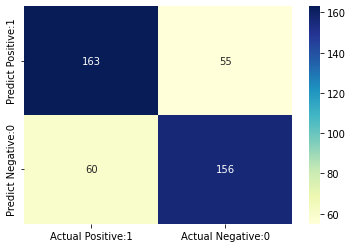

In [ ]:
# test set, do not updatee gradients
with torch.no_grad():
  accuracy_arr=[]
  loss_arr=[]
  f1_arr = []
  recall_arr=[]
  precision_arr=[]
  labels_arr=[]
  predictions_arr=[]
  auc_arr=[]
  corr_num = 0
  sample_num=0

  for indiv, labels in test_loader:
    indiv =   indiv.to(device)
    labels = labels.to(device)
    
    output = model(indiv)

    sample_num += labels.shape[0]
    predictions = torch.round(output)
    corr_num += (predictions == labels).sum().item()

    loss = loss_function(output, labels)
    loss_arr.append(loss)
    accuracy = corr_num / sample_num
    accuracy_arr.append(accuracy)

    f1 = f1_score(predictions, labels, labels=labels)
    f1_arr.append(f1)
    recall = recall_score(predictions, labels, labels=labels)
    precision = precision_score(predictions, labels, labels=labels)
    auc = roc_auc_score(predictions, labels, labels=labels)
    recall_arr.append(recall)
    precision_arr.append(precision)
    auc_arr.append(auc)
    labels_arr += labels.tolist()
    predictions_arr += predictions.tolist()

print(my_cm(labels_arr, predictions_arr))

print(f'Average Accuracy: {sum(accuracy_arr)/len(accuracy_arr)}')
print(f'Average Cost/Loss: {sum(loss_arr)/len(loss_arr)}')
print(f'Average F1 score:\t{np.average(np.array(f1_arr))}')
print(f'Average AUC score:\t{np.average(np.array(auc_arr))}')
print(f'Average Recall score:\t{np.average(np.array(recall_arr))}')
print(f'Average Precision score:\t{np.average(np.array(precision_arr))}')


Cross Validation

In [ ]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

Reset trainable parameters of layer = Linear(in_features=147, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=16, bias=True)
Reset trainable parameters of layer = Linear(in_features=16, out_features=8, bias=True)
Reset trainable parameters of layer = Linear(in_features=8, out_features=1, bias=True)
Reset trainable parameters of layer = BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=147, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=16, b

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Reset trainable parameters of layer = Linear(in_features=147, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=16, bias=True)
Reset trainable parameters of layer = Linear(in_features=16, out_features=8, bias=True)
Reset trainable parameters of layer = Linear(in_features=8, out_features=1, bias=True)
Reset trainable parameters of layer = BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=147, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=16, b

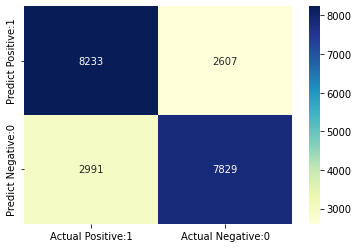

In [ ]:
loss_function = nn.BCELoss()

num_batch = 8
num_epochs = 10
accuracy_arr=[]
loss_arr=[]
f1_arr = []
recall_arr=[]
precision_arr=[]
labels_arr=[]
predictions_arr=[]
f1_fold=[]
auc_arr=[]
for train_index, test_index in kf.split(data):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  train_loader=torch.utils.data.DataLoader(data_class(X_train,y_train),batch_size=num_batch,shuffle=True)
  test_loader=torch.utils.data.DataLoader(data_class(X_test,y_test), batch_size=num_batch)

  model = ANN(147, 1)
  model.to(device)
  model.apply(reset_weights)
  optimizer = torch.optim.Adam(model.parameters())
  total_steps = len(train_loader)
  for epoch in range(num_epochs):
    for i, (samples,labels) in enumerate (train_loader):
      samples = samples.to(device)
      labels = labels.to(device)

      output = model.forward(samples)
      loss = loss_function(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    with torch.no_grad():
      corr_num = 0
      sample_num=0

      for indv, labels in test_loader:
        indv =  indv.to(device)
        labels = labels.to(device)
        if(indv.shape[0] < 2):
          continue
        output = model(indv)

        sample_num += labels.shape[0]
        predictions = torch.round(output)
        corr_num += (predictions == labels).sum().item()

        loss = loss_function(output, labels)
        loss_arr.append(loss)
        accuracy = corr_num / sample_num
        accuracy_arr.append(accuracy)

        f1 = f1_score(predictions, labels, labels=labels)
        f1_arr.append(f1)
        recall = recall_score(predictions, labels, labels=labels)
        precision = precision_score(predictions, labels, labels=labels)
        auc=roc_auc_score(predictions, labels, labels=labels)
        f1_arr.append(f1)
        auc_arr.append(auc)
        recall_arr.append(recall)
        precision_arr.append(precision)
        labels_arr += labels.tolist()
        predictions_arr += predictions.tolist()
print(my_cm(labels_arr, predictions_arr))

print(f'Average Accuracy: {sum(accuracy_arr)/len(accuracy_arr)}')
print(f'Average Cost/Loss: {sum(loss_arr)/len(loss_arr)}')
print(f'Average F1 score:\t{np.average(np.array(f1_arr))}')
print(f'Average AUC score:\t{np.average(np.array(auc_arr))}')
print(f'Average Recall score:\t{np.average(np.array(recall_arr))}')
print(f'Average Precision score:\t{np.average(np.array(precision_arr))}')
